# **쇼핑몰 지점별 매출액 예측 경진대회**
- 코드실행은 Google Colab의 CPU, Standard RAM 환경에서 진행했습니다.
- 작성자 : standing-o

## **0. Import Packages**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install h5py
!pip install typing-extensions
!pip install wheel
!pip install folium==0.2.1
!pip install markupsafe==2.0.1
!pip install -U pandas-profiling
!pip install catboost
!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq

In [18]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import pandas_profiling
import seaborn as sns
import random as rn
import os
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from collections import Counter
from pycaret.regression import *

%matplotlib inline
warnings.filterwarnings(action='ignore')
%cd '/content/drive/MyDrive/Shopping_sales_revenue'

In [4]:
print("numpy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
print("matplotlib version: {}". format(matplotlib.__version__))
print("scikit-learn version: {}". format(sklearn.__version__))

numpy version: 1.21.6
pandas version: 1.3.5
matplotlib version: 3.2.2
scikit-learn version: 0.23.2


In [6]:
# reproducibility
def seed_all(seed_num):
    rn.seed(seed_num)
    os.environ['PYTHONHASHSEED'] = str(seed_num)
    np.random.seed(seed_num)

seed_all(42)

## **1. Load and Check dataset**

In [7]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

print(train.shape)
train.head()

(6255, 13)


id  Store        Date  Temperature  Fuel_Price  Promotion1  Promotion2  \
0   1      1  05/02/2010        42.31       2.572         NaN         NaN   
1   2      1  12/02/2010        38.51       2.548         NaN         NaN   
2   3      1  19/02/2010        39.93       2.514         NaN         NaN   
3   4      1  26/02/2010        46.63       2.561         NaN         NaN   
4   5      1  05/03/2010        46.50       2.625         NaN         NaN   

   Promotion3  Promotion4  Promotion5  Unemployment  IsHoliday  Weekly_Sales  
0         NaN         NaN         NaN         8.106      False    1643690.90  
1         NaN         NaN         NaN         8.106       True    1641957.44  
2         NaN         NaN         NaN         8.106      False    1611968.17  
3         NaN         NaN         NaN         8.106      False    1409727.59  
4         NaN         NaN         NaN         8.106      False    1554806.68

In [8]:
pr = train.profile_report()
pr.to_file('pr_report.html')
pr

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### **Summary of Pandas profiling : Alert**
#### **High correlation**
`Promotion1`-`Promotion4`-`Promotion5`-`Weekly_Sales`
`Fuel_Price`-`Unemployment`

### **High cardinality**
`Date`

### **Missing values**
↪ `Promotion 1-5` have missing values

## **2. EDA**
- `Weekly_Sales` : 주간 매출액 **(target)**
- `id` : 샘플 아이디 | `Store` : 쇼핑몰 지점 | `Date` : 주 단위(Weekly) 날짜
- `Temperature` : 해당 쇼핑몰 주변 기온 | `Fuel_Price` : 해당 쇼핑몰 주변 연료 가격
- `Promotion 1~5` : 해당 쇼핑몰의 비식별화된 프로모션 정보 | `Unemployment` : 해당 쇼핑몰 지역의 실업률
- `IsHoliday` : 해당 기간의 공휴일 포함 여부

### **Data type**
- Numeric(11) : `id`, `Store`, `Temperature`, `Fuel_Price`, `Promotion1-5`, `Unemployment`, `Weekly_Sales`
- Categorical(1) : `Date`
- Boolean(1) : `IsHoliday`

In [11]:
train.isnull().sum()

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

In [12]:
test.isnull().sum()

id                0
Store             0
Date              0
Temperature       0
Fuel_Price        0
Promotion1        2
Promotion2      135
Promotion3       19
Promotion4       34
Promotion5        0
Unemployment      0
IsHoliday         0
dtype: int64

In [97]:
df_train = train.copy()
df_test = test.copy()

### **2-(1). Missing Values**
📝 `Promotion 1-5` 변수의 결측치들을 0으로 채워줍니다.

In [98]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

df_train.isnull().sum()

id              0
Store           0
Date            0
Temperature     0
Fuel_Price      0
Promotion1      0
Promotion2      0
Promotion3      0
Promotion4      0
Promotion5      0
Unemployment    0
IsHoliday       0
Weekly_Sales    0
dtype: int64

### **2-(2). Visualization**
📝 먼저 target값의 분포를 확인하겠습니다.

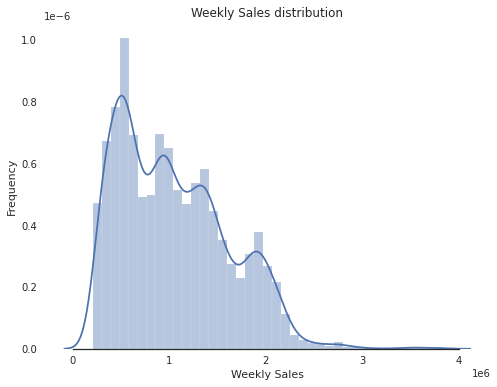

In [99]:
# Before normalization

sns.set_style("white")
sns.set_color_codes(palette = 'deep')
f, ax = plt.subplots(figsize = (8, 6))

sns.distplot(df_train['Weekly_Sales'], color = 'b')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Weekly Sales")
ax.set(title="Weekly Sales distribution")

sns.despine(trim=True, left=True)  # delete border
plt.show()

📝 Target값이 왼쪽으로 치우쳐 있으므로 log(1+x) 함수를 적용해보겠습니다.

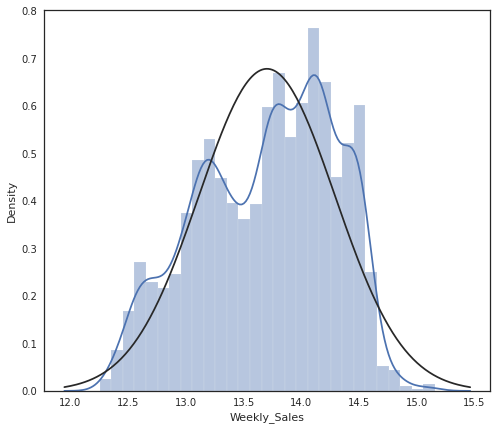

In [100]:
df_train['Weekly_Sales'] = np.log1p(df_train['Weekly_Sales'])

# new distribution
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(df_train['Weekly_Sales'] , fit=norm, color="b");

📝 위 그래프의 검은선은 normal distribution에 해당합니다.

## **3. Feature Engineering**
### **3-(1). `Date`**


In [71]:
df_train['Date']

0       05/02/2010
1       12/02/2010
2       19/02/2010
3       26/02/2010
4       05/03/2010
           ...    
6250    31/08/2012
6251    07/09/2012
6252    14/09/2012
6253    21/09/2012
6254    28/09/2012
Name: Date, Length: 6255, dtype: object

📝 가장 과거 시점의 날짜로부터 며칠이 지났는지를 뜻하는 `Pass_date` 변수를 새롭게 생성합니다.

In [72]:
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%d/%m/%Y')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%d/%m/%Y')

df_train['Date']

0      2010-02-05
1      2010-02-12
2      2010-02-19
3      2010-02-26
4      2010-03-05
          ...    
6250   2012-08-31
6251   2012-09-07
6252   2012-09-14
6253   2012-09-21
6254   2012-09-28
Name: Date, Length: 6255, dtype: datetime64[ns]

In [73]:
df_train['Date'].min()

Timestamp('2010-02-05 00:00:00')

In [74]:
print('Minimum date:', df_train['Date'].min())
print('Maximum date:', df_train['Date'].max())

Minimum date: 2010-02-05 00:00:00
Maximum date: 2012-09-28 00:00:00


In [75]:
train_diff_date = df_train['Date'] - df_train['Date'].min()
test_diff_date = df_test['Date'] - df_test['Date'].min()

df_train["Pass_date"] = [i.days for i in train_diff_date]
df_test["Pass_date"] = [i.days for i in test_diff_date]

In [76]:
df_train["Pass_date"]

0         0
1         7
2        14
3        21
4        28
       ... 
6250    938
6251    945
6252    952
6253    959
6254    966
Name: Pass_date, Length: 6255, dtype: int64

### **3-(2). `IsHoliday`**
📝 Categorical 데이터를 수치형으로 변환해줍니다.

In [77]:
df_train['IsHoliday'].head()

0    False
1     True
2    False
3    False
4    False
Name: IsHoliday, dtype: bool

In [78]:
df_train = df_train.replace({'IsHoliday' : True}, 1)
df_train = df_train.replace({'IsHoliday' : False}, 0)

df_test = df_test.replace({'IsHoliday' : True}, 1)
df_test = df_test.replace({'IsHoliday' : False}, 0)

In [79]:
df_train['IsHoliday'].head()

0    0
1    1
2    0
3    0
4    0
Name: IsHoliday, dtype: int64

In [80]:
df_test['IsHoliday'].head()

0    0
1    0
2    0
3    0
4    0
Name: IsHoliday, dtype: int64

### **3-(3). Correlation**
📝 앞서 수행한 pandas profiling report의 alert를 참고하여 상관계수를 계산했습니다.

In [81]:
cor_fts = ['Promotion1', 'Promotion4', 'Promotion5', 'Fuel_Price', 'Unemployment', 'Weekly_Sales']

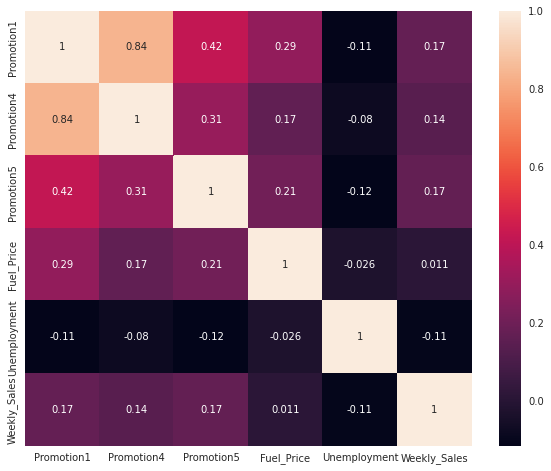

In [82]:
plt.figure(figsize = (10,8))
sns.heatmap(df_train[cor_fts].corr(), annot=True)
plt.show()

### **3-(4). Visualization**
📝 모든 수치형 변수의 box plot을 확인했습니다.

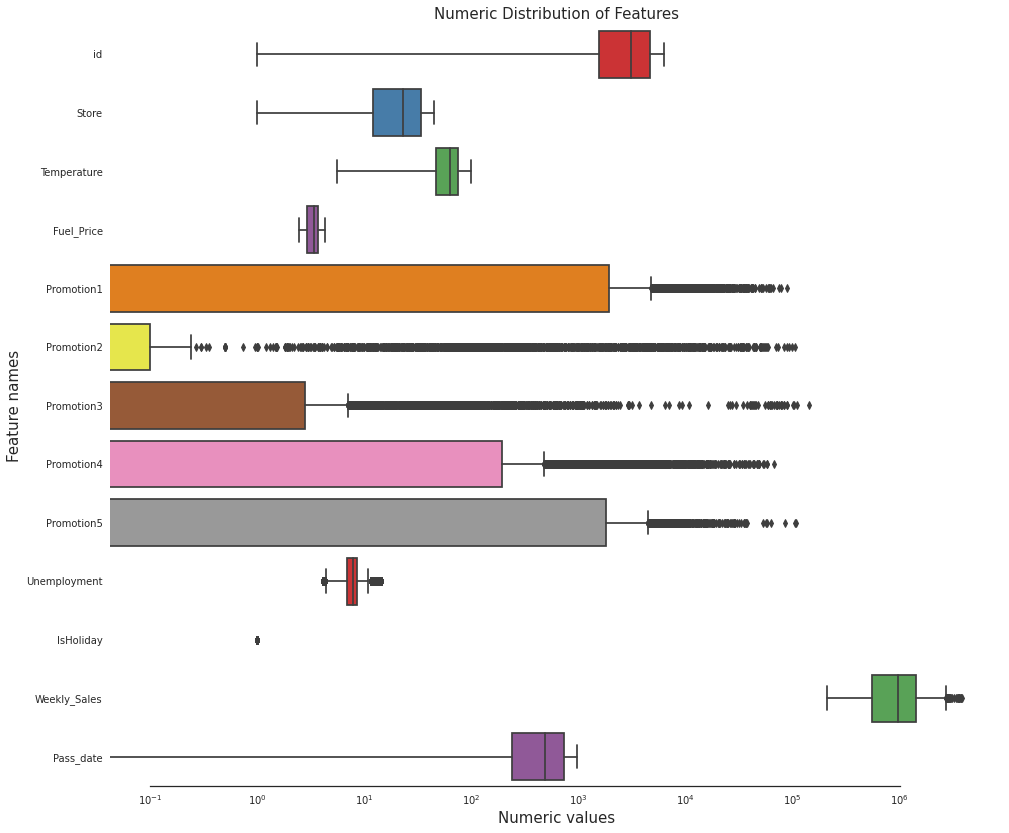

In [83]:
# Box plots for all our numeric features
f, ax = plt.subplots(figsize=(16, 14))
ax.set_xscale("log")

ax = sns.boxplot(data = df_train , orient="h", palette="Set1")

ax.xaxis.grid(False)

plt.xlabel("Numeric values", fontsize = 15)
plt.ylabel("Feature names", fontsize = 15)
plt.title("Numeric Distribution of Features", fontsize = 15)
sns.despine(trim = True, left = True)

In [84]:
train_data = df_train.copy()
test_data = df_test.copy()

## **4. Modeling**
📝 pycaret을 활용했습니다.

In [85]:
train_x = train_data.drop(['id', 'Date'], axis = 1)
test_x = test_data.drop(['id', 'Date'], axis = 1)

In [86]:
train_x.head()

Store  Temperature  Fuel_Price  Promotion1  Promotion2  Promotion3  \
0      1        42.31       2.572         0.0         0.0         0.0   
1      1        38.51       2.548         0.0         0.0         0.0   
2      1        39.93       2.514         0.0         0.0         0.0   
3      1        46.63       2.561         0.0         0.0         0.0   
4      1        46.50       2.625         0.0         0.0         0.0   

   Promotion4  Promotion5  Unemployment  IsHoliday  Weekly_Sales  Pass_date  
0         0.0         0.0         8.106          0    1643690.90          0  
1         0.0         0.0         8.106          1    1641957.44          7  
2         0.0         0.0         8.106          0    1611968.17         14  
3         0.0         0.0         8.106          0    1409727.59         21  
4         0.0         0.0         8.106          0    1554806.68         28

In [87]:
test_x.head()

Store  Temperature  Fuel_Price  Promotion1  Promotion2  Promotion3  \
0      1        68.55       3.617     8077.89        0.00       18.22   
1      1        62.99       3.601     2086.18        0.00        8.11   
2      1        67.97       3.594      950.33        0.00        4.93   
3      1        69.16       3.506     2585.85       31.75        6.00   
4      2        70.27       3.617     6037.76        0.00       10.04   

   Promotion4  Promotion5  Unemployment  IsHoliday  Pass_date  
0     3617.43     3626.14         6.573          0          0  
1      602.36     5926.45         6.573          0          7  
2       80.25     2312.85         6.573          0         14  
3     1057.16     1305.01         6.573          0         21  
4     3027.37     3853.40         6.170          0          0

In [88]:
seed_num = 42
py_reg = setup(train_x, target = 'Weekly_Sales', session_id = seed_num, silent = True)

Description             Value
0                               session_id                42
1                                   Target      Weekly_Sales
2                            Original Data        (6255, 12)
3                           Missing Values             False
4                         Numeric Features                10
5                     Categorical Features                 1
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set        (4378, 11)
10                    Transformed Test Set        (1877, 11)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number                10
15                                CPU Jobs                -1
16                                 Use GPU             False
17                          Log Experiment             False
18                         Experiment Name  reg-default-name
19                                     USI              a3f6
20                         Imputation Type            simple
21          Iterative Imputation Iteration              None
22                         Numeric Imputer              mean
23      Iterative Imputation Numeric Model              None
24                     Categorical Imputer          constant
25  Iterative Imputation Categorical Model              None
26           Unknown Categoricals Handling    least_frequent
27                               Normalize             False
28                        Normalize Method              None
29                          Transformation             False
30                   Transformation Method              None
31                                     PCA             False
32                              PCA Method              None
33                          PCA Components              None
34                     Ignore Low Variance             False
35                     Combine Rare Levels             False
36                    Rare Level Threshold              None
37                         Numeric Binning             False
38                         Remove Outliers             False
39                      Outliers Threshold              None
40                Remove Multicollinearity             False
41             Multicollinearity Threshold              None
42             Remove Perfect Collinearity              True
43                              Clustering             False
44                    Clustering Iteration              None
45                     Polynomial Features             False
46                       Polynomial Degree              None
47                    Trignometry Features             False
48                    Polynomial Threshold              None
49                          Group Features             False
50                       Feature Selection             False
51                Feature Selection Method           classic
52            Features Selection Threshold              None
53                     Feature Interaction             False
54                           Feature Ratio             False
55                   Interaction Threshold              None
56                        Transform Target             False
57                 Transform Target Method           box-cox

INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='Weekly_Sales',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_st...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [89]:
compare_models()

Model          MAE           MSE  \
catboost               CatBoost Regressor   66726.0766  1.000903e+10   
lightgbm  Light Gradient Boosting Machine   65885.1998  1.120158e+10   
rf                Random Forest Regressor   75157.7453  1.985265e+10   
et                  Extra Trees Regressor   78340.2245  2.022359e+10   
dt                Decision Tree Regressor   97108.8982  3.414072e+10   
gbr           Gradient Boosting Regressor  155074.2011  4.209142e+10   
ada                    AdaBoost Regressor  401210.6301  2.183525e+11   
knn                 K Neighbors Regressor  398224.9344  2.501274e+11   
ridge                    Ridge Regression  414986.4750  2.640844e+11   
lar                Least Angle Regression  414987.2063  2.640865e+11   
lasso                    Lasso Regression  414987.1812  2.640863e+11   
llar         Lasso Least Angle Regression  415004.8671  2.640819e+11   
lr                      Linear Regression  414989.4625  2.640906e+11   
en                            Elastic Net  416598.1062  2.657288e+11   
br                         Bayesian Ridge  417473.2057  2.662536e+11   
omp           Orthogonal Matching Pursuit  436252.5058  2.830839e+11   
dummy                     Dummy Regressor  467288.9438  3.169362e+11   
huber                     Huber Regressor  494682.9661  3.929263e+11   
par          Passive Aggressive Regressor  905354.6661  5.956244e+12   

                  RMSE       R2   RMSLE    MAPE  TT (Sec)  
catboost  9.985725e+04   0.9684  0.1032  0.0747     4.400  
lightgbm  1.055994e+05   0.9647  0.1037  0.0710     0.143  
rf        1.401431e+05   0.9375  0.1082  0.0704     2.503  
et        1.416609e+05   0.9362  0.1115  0.0754     1.468  
dt        1.827454e+05   0.8922  0.1368  0.0887     0.067  
gbr       2.045654e+05   0.8672  0.2378  0.2003     0.871  
ada       4.671186e+05   0.3098  0.5476  0.6107     0.473  
knn       4.999311e+05   0.2093  0.5224  0.5147     0.104  
ridge     5.136950e+05   0.1654  0.5527  0.5818     0.014  
lar       5.136970e+05   0.1654  0.5527  0.5818     0.016  
lasso     5.136968e+05   0.1654  0.5527  0.5818     0.034  
llar      5.136926e+05   0.1654  0.5527  0.5818     0.015  
lr        5.137009e+05   0.1654  0.5527  0.5818     0.068  
en        5.153108e+05   0.1600  0.5548  0.5847     0.036  
br        5.158208e+05   0.1584  0.5554  0.5856     0.018  
omp       5.318378e+05   0.1059  0.5771  0.6217     0.014  
dummy     5.627651e+05  -0.0006  0.6066  0.6633     0.011  
huber     6.265757e+05  -0.2419  0.6902  0.6291     0.134  
par       2.072251e+06 -17.9855  0.9195  1.0153     0.037

INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 2
INFO:logs:<catboost.core.CatBoostRegressor object at 0x7f71eacb1b90>
INFO:logs:compare_models() succesfully completed......................................


📝 상위 3개의 모델을 혼합한 모델을 생성합니다.

In [90]:
catboost = create_model('catboost', verbose = False)
rf = create_model('rf', verbose = False)
lgbm = create_model('lightgbm', verbose = False)

INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=catboost, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=False, system=True, metrics=None, experiment_custom_tags=None, add_to_model_list=True, probability_threshold=None, display=None, return_train_score=False, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:CatBoost Regressor Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with KFold(n_splits=10, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean and std
INFO:logs:Creating metrics dataframe
INFO:logs:Finalizing model
INFO:logs:Uploading results into container
INFO:logs:Uploading model into container now
INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:

In [91]:
blended_model = blend_models(estimator_list = [catboost, rf, lgbm])

MAE           MSE         RMSE      R2   RMSLE    MAPE
Fold                                                               
0     66044.4878  1.222239e+10  110554.9052  0.9618  0.0933  0.0669
1     60105.3849  8.469630e+09   92030.5908  0.9706  0.0863  0.0612
2     62404.8432  1.117169e+10  105696.2199  0.9642  0.0860  0.0623
3     62395.6048  1.011289e+10  100562.8673  0.9677  0.0896  0.0631
4     63941.9630  9.692068e+09   98448.3032  0.9675  0.0955  0.0677
5     63888.3766  1.172139e+10  108265.3850  0.9615  0.0956  0.0669
6     59503.2204  9.788705e+09   98937.8830  0.9721  0.0927  0.0632
7     67693.5106  1.333773e+10  115489.1030  0.9595  0.0878  0.0641
8     59362.8673  7.845487e+09   88574.7535  0.9756  0.0899  0.0658
9     63281.2697  1.231228e+10  110960.7303  0.9627  0.0924  0.0648
Mean  62862.1528  1.066743e+10  102952.0741  0.9663  0.0909  0.0646
Std    2596.4987  1.686528e+09    8264.2147  0.0050  0.0034  0.0021

INFO:logs:create_model_container: 23
INFO:logs:master_model_container: 23
INFO:logs:display_container: 6
INFO:logs:VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7f71e40a8150>),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
             

📝 전체 데이터로 마지막 학습을 진행하고 test 예측을 생성합니다.

In [ ]:
final_model = finalize_model(blended_model)

In [ ]:
prediction = predict_model(final_model, data = test_x)

In [95]:
pred = np.expm1(prediction['Label'])

📝 추후 전처리 부분을 계속 수정할 예정입니다. 도움이 됐길 바랍니다👍👍